In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.colors as clrs
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib nbagg

## 0. Sample data 생성
f = -x1 - x2 를 dicision boundary로 갖는 데이터를 생성한다

In [2]:
def data2d_create(center,num,r = 3):
    data = np.random.randn(num,2)*r
    data[:,0] = data[:,0] + center[0]
    data[:,1] = data[:,1] + center[1]
    return data

In [3]:
num_of_data = 100
class1=data2d_create((-5,-5),num_of_data)
class2=data2d_create((15,15),num_of_data)

class1=np.concatenate([class1,np.ones((num_of_data,1))],1)
class2=np.concatenate([class2,-np.ones((num_of_data,1))],1)

print(class1.shape,class2.shape)

(100, 3) (100, 3)


In [4]:
class1[0][0] =-8000
class1[0][1] = 1000 # -Y\*y vs Max(0,-Y\*y)

In [5]:
class1[:5]

array([[ -8.00000000e+03,   1.00000000e+03,   1.00000000e+00],
       [ -3.60041150e+00,  -4.02511925e+00,   1.00000000e+00],
       [ -7.32829754e+00,  -9.90873380e+00,   1.00000000e+00],
       [ -8.88146171e+00,  -6.09313971e+00,   1.00000000e+00],
       [ -7.35806925e-01,  -5.84049551e+00,   1.00000000e+00]])

In [6]:
class2[:5]

array([[ 17.15659055,  13.23238839,  -1.        ],
       [ 18.67746595,  13.36327558,  -1.        ],
       [ 12.75873552,  19.11818559,  -1.        ],
       [ 13.79138712,  14.11823002,  -1.        ],
       [ 16.43354263,  15.48173586,  -1.        ]])

<IPython.core.display.Javascript object>


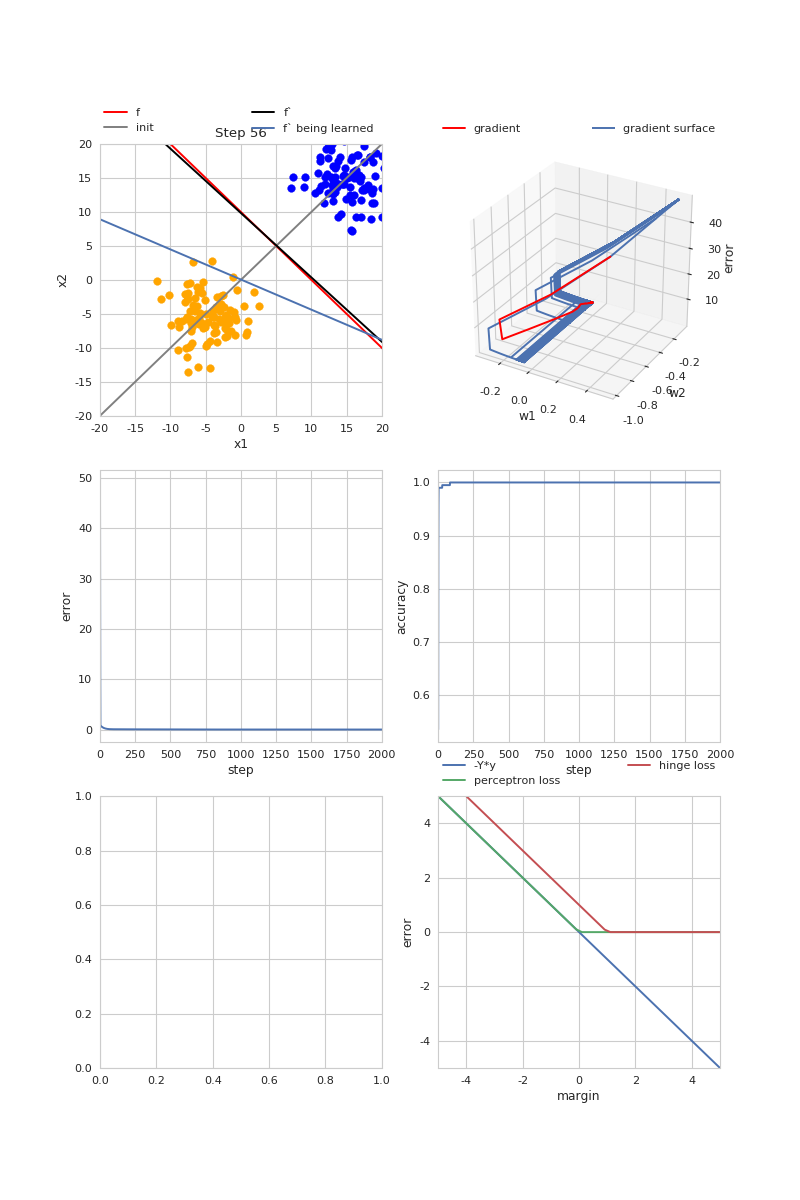

In [7]:
fig, [[ax1,ax2],[ax3,ax4],[_,_]] = plt.subplots(nrows=3,ncols=2,figsize=(10,15),dpi=80)

ax1.set_ylim(-20,20)
ax1.set_xlim(-20,20)
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")

x = np.linspace(-8000,8000,100)
ax1.plot(x,-x+10,label = 'f',c='red')
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
ax1.scatter(class1[:,0],class1[:,1],c='orange',)
ax1.scatter(class2[:,0],class2[:,1],c='blue')

ax2.axis('off')
_.set_xlabel("margin")
_.set_ylabel("error")

margin = np.linspace(-10,10,100)
_.set_ylim(-5,5)
_.set_xlim(-5,5)
_.plot(margin,-margin,label='-Y*y')
_.plot(margin,np.maximum(0,-margin),label='perceptron loss')
_.plot(margin,np.maximum(0,1-margin),label='hinge loss')
_.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

In [8]:
train = np.concatenate([class1,class2],0)
np.random.shuffle(train)

train[:5]

array([[ 20.98363454,  15.42289771,  -1.        ],
       [ -1.63775271,  -5.63308715,   1.        ],
       [ -7.60415228,  -0.67229175,   1.        ],
       [ 13.75719133,   9.24288471,  -1.        ],
       [ -7.74984435,  -5.7119082 ,   1.        ]])

In [9]:
train_X = train[:,:2]
train_Y = train[:,2]

### hyper parameter 입력

In [10]:
def binary_activation(x):
    cond = tf.less(x, tf.zeros(tf.shape(x)))
    out = tf.where(cond, -tf.ones(tf.shape(x)), tf.ones(tf.shape(x)))
    return out

In [11]:
learning_rate = 0.01
epoch = 2000

### tesorflow symbol 선언

In [12]:
X = tf.placeholder(tf.float32,shape =[None,2])
Y = tf.placeholder(tf.float32,shape =[None,1])

W = tf.Variable([[1.0],
                 [-1.0]])
b = tf.Variable(tf.zeros([1]))

### symbol 관계정의

In [13]:
f = tf.add(tf.matmul(X,W),b)

accuracy = tf.reduce_mean(tf.cast(tf.equal(binary_activation(f),Y),tf.float32))

#error = tf.reduce_mean(-Y*f) # not use max
#error = tf.reduce_mean(tf.maximum(0.0,-Y*f)) # perceptron loss
#error = tf.reduce_mean(tf.maximum(0.0,1-Y*f)) # hinge loss
error = tf.reduce_sum(tf.square(W))+tf.reduce_mean(tf.maximum(0.0,1-Y*f))
#error = tf.losses.hinge_loss(Y,f)
        

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(error)

### seesion 정의 및 실행

In [14]:
w_list = []
b_list = []
error_list = []
acc_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    init_w = sess.run(W)
    init_b = sess.run(b)
    
    ax1.plot(x,-(init_w[0]*x+init_b)/init_w[1],label='init',c='gray')
    
    w_list.append([init_w[0][0],init_w[1][0]])
    b_list.append(init_b[0])
    
    for step in range(epoch):
        
        _,weight,bias, cost_val,acc_val = sess.run([train_op,W,b, error, accuracy], 
                                       feed_dict={X: train_X, Y: train_Y.reshape(len(train_Y),1)})
        
        print("step: ",step,"\tw1, w2: ",weight[0],weight[1],"\tb: ",bias,"\terror: ", cost_val,"\tacc: ",acc_val)
        
        w_list.append([weight[0][0],weight[1][0]])
        b_list.append(bias[0])
        error_list.append(cost_val)
        acc_list.append(acc_val)
        
        
    ax1.plot(x,-(w_list[-1][0]*x+bias[-1])/w_list[-1][1],label='f`',c='black')
    
    
    # 최적화가 완료된 모델에 테스트 값을 넣고 결과가 잘 나오는지 확인해봅니다.
#     print("\n=== Test ===")
#     print("X:, ",test)
#     print("Y:", sess.run(f, feed_dict={X: test}))

step:  0 	w1, w2:  [ 0.51431012] [-0.98013991] 	b:  [-0.0005] 	error:  49.115 	acc:  0.535
step:  1 	w1, w2:  [ 0.0898158] [-0.91559148] 	b:  [ 0.00065] 	error:  27.1087 	acc:  0.875
step:  2 	w1, w2:  [-0.31506896] [-0.84725112] 	b:  [ 0.0012] 	error:  9.10228 	acc:  0.96
step:  3 	w1, w2:  [-0.30927783] [-0.83009976] 	b:  [ 0.0014] 	error:  0.838485 	acc:  0.99
step:  4 	w1, w2:  [-0.30360255] [-0.81329143] 	b:  [ 0.0016] 	error:  0.806038 	acc:  0.99
step:  5 	w1, w2:  [-0.29804075] [-0.79681927] 	b:  [ 0.0018] 	error:  0.774876 	acc:  0.99
step:  6 	w1, w2:  [-0.2925902] [-0.78067654] 	b:  [ 0.002] 	error:  0.744947 	acc:  0.99
step:  7 	w1, w2:  [-0.28724867] [-0.7648567] 	b:  [ 0.0022] 	error:  0.716204 	acc:  0.99
step:  8 	w1, w2:  [-0.28201395] [-0.74935323] 	b:  [ 0.0024] 	error:  0.688599 	acc:  0.99
step:  9 	w1, w2:  [-0.27688393] [-0.73415983] 	b:  [ 0.0026] 	error:  0.662087 	acc:  0.99
step:  10 	w1, w2:  [-0.27185652] [-0.71927029] 	b:  [ 0.0028] 	error:  0.636624 	acc

step:  148 	w1, w2:  [-0.1200662] [-0.13517232] 	b:  [ 0.09965007] 	error:  0.0643998 	acc:  1.0
step:  149 	w1, w2:  [-0.11977845] [-0.13491453] 	b:  [ 0.10065007] 	error:  0.064287 	acc:  1.0
step:  150 	w1, w2:  [-0.11978335] [-0.13474016] 	b:  [ 0.10170007] 	error:  0.0641768 	acc:  1.0
step:  151 	w1, w2:  [-0.11978815] [-0.13456927] 	b:  [ 0.10275008] 	error:  0.0640635 	acc:  1.0
step:  152 	w1, w2:  [-0.11950597] [-0.13432354] 	b:  [ 0.10375008] 	error:  0.0639539 	acc:  1.0
step:  153 	w1, w2:  [-0.11951633] [-0.13416098] 	b:  [ 0.10480008] 	error:  0.0638415 	acc:  1.0
step:  154 	w1, w2:  [-0.11923958] [-0.13392341] 	b:  [ 0.10580008] 	error:  0.0637315 	acc:  1.0
step:  155 	w1, w2:  [-0.11925526] [-0.13376886] 	b:  [ 0.10685009] 	error:  0.0636203 	acc:  1.0
step:  156 	w1, w2:  [-0.11898373] [-0.13353914] 	b:  [ 0.10785009] 	error:  0.0635101 	acc:  1.0
step:  157 	w1, w2:  [-0.11900453] [-0.13339227] 	b:  [ 0.10890009] 	error:  0.0633997 	acc:  1.0
step:  158 	w1, w2:  [

step:  234 	w1, w2:  [-0.10943972] [-0.12488622] 	b:  [ 0.18645021] 	error:  0.0553557 	acc:  1.0
step:  235 	w1, w2:  [-0.1093645] [-0.12483415] 	b:  [ 0.18745022] 	error:  0.0552548 	acc:  1.0
step:  236 	w1, w2:  [-0.10929079] [-0.12478312] 	b:  [ 0.18845022] 	error:  0.055154 	acc:  1.0
step:  237 	w1, w2:  [-0.10921855] [-0.12473311] 	b:  [ 0.18945022] 	error:  0.0550532 	acc:  1.0
step:  238 	w1, w2:  [-0.10914775] [-0.1246841] 	b:  [ 0.19045022] 	error:  0.0549524 	acc:  1.0
step:  239 	w1, w2:  [-0.10907837] [-0.12463608] 	b:  [ 0.19145022] 	error:  0.0548517 	acc:  1.0
step:  240 	w1, w2:  [-0.10901038] [-0.12458901] 	b:  [ 0.19245023] 	error:  0.054751 	acc:  1.0
step:  241 	w1, w2:  [-0.10890696] [-0.12425086] 	b:  [ 0.19340022] 	error:  0.0546519 	acc:  1.0
step:  242 	w1, w2:  [-0.1088424] [-0.1242115] 	b:  [ 0.19440022] 	error:  0.0545532 	acc:  1.0
step:  243 	w1, w2:  [-0.10877913] [-0.12417293] 	b:  [ 0.19540022] 	error:  0.0544526 	acc:  1.0
step:  244 	w1, w2:  [-0.1

step:  319 	w1, w2:  [-0.10060153] [-0.1129235] 	b:  [ 0.26755014] 	error:  0.0473315 	acc:  1.0
step:  320 	w1, w2:  [-0.10066628] [-0.11281866] 	b:  [ 0.26850015] 	error:  0.0472428 	acc:  1.0
step:  321 	w1, w2:  [-0.10042107] [-0.11266667] 	b:  [ 0.26940015] 	error:  0.0471564 	acc:  1.0
step:  322 	w1, w2:  [-0.10018076] [-0.11251773] 	b:  [ 0.27030015] 	error:  0.0470672 	acc:  1.0
step:  323 	w1, w2:  [-0.10025393] [-0.11242101] 	b:  [ 0.27125016] 	error:  0.0469803 	acc:  1.0
step:  324 	w1, w2:  [-0.10001697] [-0.11227697] 	b:  [ 0.27215016] 	error:  0.0468931 	acc:  1.0
step:  325 	w1, w2:  [-0.09978474] [-0.11213582] 	b:  [ 0.27305016] 	error:  0.0468045 	acc:  1.0
step:  326 	w1, w2:  [-0.09986583] [-0.11204673] 	b:  [ 0.27400017] 	error:  0.0467186 	acc:  1.0
step:  327 	w1, w2:  [-0.09963662] [-0.11191019] 	b:  [ 0.27490017] 	error:  0.0466313 	acc:  1.0
step:  328 	w1, w2:  [-0.099412] [-0.11177637] 	b:  [ 0.27580017] 	error:  0.0465432 	acc:  1.0
step:  329 	w1, w2:  [-

step:  405 	w1, w2:  [-0.09091739] [-0.10478387] 	b:  [ 0.34500018] 	error:  0.0401494 	acc:  1.0
step:  406 	w1, w2:  [-0.09086715] [-0.10479258] 	b:  [ 0.34590018] 	error:  0.0400698 	acc:  1.0
step:  407 	w1, w2:  [-0.09077302] [-0.10452761] 	b:  [ 0.34675017] 	error:  0.0399922 	acc:  1.0
step:  408 	w1, w2:  [-0.09068078] [-0.10426793] 	b:  [ 0.34760016] 	error:  0.0399122 	acc:  1.0
step:  409 	w1, w2:  [-0.09063527] [-0.10428696] 	b:  [ 0.34850016] 	error:  0.0398354 	acc:  1.0
step:  410 	w1, w2:  [-0.09054578] [-0.1040321] 	b:  [ 0.34935015] 	error:  0.039756 	acc:  1.0
step:  411 	w1, w2:  [-0.09050298] [-0.10405584] 	b:  [ 0.35025015] 	error:  0.0396778 	acc:  1.0
step:  412 	w1, w2:  [-0.09041613] [-0.1038056] 	b:  [ 0.35110015] 	error:  0.0396002 	acc:  1.0
step:  413 	w1, w2:  [-0.09033103] [-0.10356037] 	b:  [ 0.35195014] 	error:  0.039521 	acc:  1.0
step:  414 	w1, w2:  [-0.09029251] [-0.10359354] 	b:  [ 0.35285014] 	error:  0.0394443 	acc:  1.0
step:  415 	w1, w2:  [-0

step:  569 	w1, w2:  [-0.07291128] [-0.08631595] 	b:  [ 0.47900087] 	error:  0.0287464 	acc:  1.0
step:  570 	w1, w2:  [-0.07288888] [-0.08636121] 	b:  [ 0.47980088] 	error:  0.028686 	acc:  1.0
step:  571 	w1, w2:  [-0.07274679] [-0.0862053] 	b:  [ 0.48055089] 	error:  0.028626 	acc:  1.0
step:  572 	w1, w2:  [-0.07260755] [-0.08605251] 	b:  [ 0.48130089] 	error:  0.0285654 	acc:  1.0
step:  573 	w1, w2:  [-0.07247109] [-0.08590277] 	b:  [ 0.4820509] 	error:  0.0285049 	acc:  1.0
step:  574 	w1, w2:  [-0.07233736] [-0.08575603] 	b:  [ 0.4828009] 	error:  0.0284446 	acc:  1.0
step:  575 	w1, w2:  [-0.0722063] [-0.08561222] 	b:  [ 0.48355091] 	error:  0.0283844 	acc:  1.0
step:  576 	w1, w2:  [-0.07219801] [-0.08567157] 	b:  [ 0.48435092] 	error:  0.0283246 	acc:  1.0
step:  577 	w1, w2:  [-0.07206974] [-0.08552945] 	b:  [ 0.48510092] 	error:  0.0282651 	acc:  1.0
step:  578 	w1, w2:  [-0.07194404] [-0.08539017] 	b:  [ 0.48585093] 	error:  0.0282053 	acc:  1.0
step:  579 	w1, w2:  [-0.0

step:  737 	w1, w2:  [-0.06610869] [-0.0775857] 	b:  [ 0.58725065] 	error:  0.0213808 	acc:  1.0
step:  738 	w1, w2:  [-0.06602481] [-0.07751448] 	b:  [ 0.58775067] 	error:  0.0213546 	acc:  1.0
step:  739 	w1, w2:  [-0.06594261] [-0.07744469] 	b:  [ 0.5882507] 	error:  0.0213284 	acc:  1.0
step:  740 	w1, w2:  [-0.06586205] [-0.07737631] 	b:  [ 0.58875072] 	error:  0.0213022 	acc:  1.0
step:  741 	w1, w2:  [-0.06656121] [-0.07767311] 	b:  [ 0.58920074] 	error:  0.02128 	acc:  1.0
step:  742 	w1, w2:  [-0.06646828] [-0.07760015] 	b:  [ 0.58970076] 	error:  0.0212617 	acc:  1.0
step:  743 	w1, w2:  [-0.06637721] [-0.07752865] 	b:  [ 0.59020078] 	error:  0.0212353 	acc:  1.0
step:  744 	w1, w2:  [-0.06628796] [-0.07745858] 	b:  [ 0.59070081] 	error:  0.021209 	acc:  1.0
step:  745 	w1, w2:  [-0.06620049] [-0.0773899] 	b:  [ 0.59120083] 	error:  0.0211827 	acc:  1.0
step:  746 	w1, w2:  [-0.06611478] [-0.07732261] 	b:  [ 0.59170085] 	error:  0.0211565 	acc:  1.0
step:  747 	w1, w2:  [-0.0

step:  823 	w1, w2:  [-0.06939488] [-0.07352518] 	b:  [ 0.62455171] 	error:  0.0196925 	acc:  1.0
step:  824 	w1, w2:  [-0.07054017] [-0.07424347] 	b:  [ 0.62490171] 	error:  0.01969 	acc:  1.0
step:  825 	w1, w2:  [-0.07000627] [-0.07379808] 	b:  [ 0.62525171] 	error:  0.0197133 	acc:  1.0
step:  826 	w1, w2:  [-0.06948305] [-0.07336161] 	b:  [ 0.62560171] 	error:  0.0196531 	acc:  1.0
step:  827 	w1, w2:  [-0.07062659] [-0.07408318] 	b:  [ 0.62595171] 	error:  0.0196549 	acc:  1.0
step:  828 	w1, w2:  [-0.07009096] [-0.073641] 	b:  [ 0.62630171] 	error:  0.019674 	acc:  1.0
step:  829 	w1, w2:  [-0.06956604] [-0.07320767] 	b:  [ 0.6266517] 	error:  0.019614 	acc:  1.0
step:  830 	w1, w2:  [-0.07093647] [-0.07457017] 	b:  [ 0.62690169] 	error:  0.0196268 	acc:  1.0
step:  831 	w1, w2:  [-0.07039464] [-0.07411825] 	b:  [ 0.62725168] 	error:  0.0196792 	acc:  1.0
step:  832 	w1, w2:  [-0.06986365] [-0.07367537] 	b:  [ 0.62760168] 	error:  0.0196177 	acc:  1.0
step:  833 	w1, w2:  [-0.07

step:  912 	w1, w2:  [-0.07089659] [-0.073906] 	b:  [ 0.65130132] 	error:  0.0188841 	acc:  1.0
step:  913 	w1, w2:  [-0.0726123] [-0.07552275] 	b:  [ 0.65140134] 	error:  0.018886 	acc:  1.0
step:  914 	w1, w2:  [-0.07191014] [-0.07493699] 	b:  [ 0.65170133] 	error:  0.0190041 	acc:  1.0
step:  915 	w1, w2:  [-0.07122201] [-0.07436295] 	b:  [ 0.65200132] 	error:  0.0189123 	acc:  1.0
step:  916 	w1, w2:  [-0.07132576] [-0.07416422] 	b:  [ 0.6522513] 	error:  0.0188365 	acc:  1.0
step:  917 	w1, w2:  [-0.07142742] [-0.07396946] 	b:  [ 0.65250129] 	error:  0.0188253 	acc:  1.0
step:  918 	w1, w2:  [-0.07189705] [-0.07453743] 	b:  [ 0.65270126] 	error:  0.0188209 	acc:  1.0
step:  919 	w1, w2:  [-0.07120919] [-0.07397138] 	b:  [ 0.65300125] 	error:  0.0188587 	acc:  1.0
step:  920 	w1, w2:  [-0.07168319] [-0.07453932] 	b:  [ 0.65320122] 	error:  0.0188211 	acc:  1.0
step:  921 	w1, w2:  [-0.07099961] [-0.07397323] 	b:  [ 0.65350121] 	error:  0.0188291 	acc:  1.0
step:  922 	w1, w2:  [-0.

step:  1000 	w1, w2:  [-0.07267506] [-0.07594475] 	b:  [ 0.67265052] 	error:  0.0184924 	acc:  1.0
step:  1001 	w1, w2:  [-0.07197164] [-0.07535055] 	b:  [ 0.67295051] 	error:  0.018396 	acc:  1.0
step:  1002 	w1, w2:  [-0.07206039] [-0.07513207] 	b:  [ 0.67320049] 	error:  0.0183262 	acc:  1.0
step:  1003 	w1, w2:  [-0.07214736] [-0.07491796] 	b:  [ 0.67345047] 	error:  0.0183144 	acc:  1.0
step:  1004 	w1, w2:  [-0.07260259] [-0.07546696] 	b:  [ 0.67365044] 	error:  0.0183156 	acc:  1.0
step:  1005 	w1, w2:  [-0.07190062] [-0.07488232] 	b:  [ 0.67395043] 	error:  0.0183327 	acc:  1.0
step:  1006 	w1, w2:  [-0.07359625] [-0.07647954] 	b:  [ 0.67405045] 	error:  0.0183314 	acc:  1.0
step:  1007 	w1, w2:  [-0.07287441] [-0.07587464] 	b:  [ 0.67435044] 	error:  0.0184517 	acc:  1.0
step:  1008 	w1, w2:  [-0.072167] [-0.07528184] 	b:  [ 0.67465043] 	error:  0.0183549 	acc:  1.0
step:  1009 	w1, w2:  [-0.07225184] [-0.07506473] 	b:  [ 0.67490041] 	error:  0.0182805 	acc:  1.0
step:  1010 	

step:  1087 	w1, w2:  [-0.07243738] [-0.07586083] 	b:  [ 0.69379967] 	error:  0.0178353 	acc:  1.0
step:  1088 	w1, w2:  [-0.07412227] [-0.07743848] 	b:  [ 0.69389969] 	error:  0.0178868 	acc:  1.0
step:  1089 	w1, w2:  [-0.07338991] [-0.07681441] 	b:  [ 0.69419968] 	error:  0.0179534 	acc:  1.0
step:  1090 	w1, w2:  [-0.0726722] [-0.07620282] 	b:  [ 0.69449967] 	error:  0.0178527 	acc:  1.0
step:  1091 	w1, w2:  [-0.07311693] [-0.07672612] 	b:  [ 0.69469965] 	error:  0.0178021 	acc:  1.0
step:  1092 	w1, w2:  [-0.07240467] [-0.0761163] 	b:  [ 0.69499964] 	error:  0.0178128 	acc:  1.0
step:  1093 	w1, w2:  [-0.07409022] [-0.07768884] 	b:  [ 0.69509965] 	error:  0.0178401 	acc:  1.0
step:  1094 	w1, w2:  [-0.0733585] [-0.07705976] 	b:  [ 0.69539964] 	error:  0.0179307 	acc:  1.0
step:  1095 	w1, w2:  [-0.07264141] [-0.07644326] 	b:  [ 0.69569963] 	error:  0.0178295 	acc:  1.0
step:  1096 	w1, w2:  [-0.07271677] [-0.07620292] 	b:  [ 0.69594961] 	error:  0.017777 	acc:  1.0
step:  1097 	w

step:  1174 	w1, w2:  [-0.07388188] [-0.07766234] 	b:  [ 0.71359873] 	error:  0.0173729 	acc:  1.0
step:  1175 	w1, w2:  [-0.0728153] [-0.07716833] 	b:  [ 0.71384871] 	error:  0.0173868 	acc:  1.0
step:  1176 	w1, w2:  [-0.07449264] [-0.07871983] 	b:  [ 0.71394873] 	error:  0.0174182 	acc:  1.0
step:  1177 	w1, w2:  [-0.07341384] [-0.07820468] 	b:  [ 0.71419871] 	error:  0.0174969 	acc:  1.0
step:  1178 	w1, w2:  [-0.07313472] [-0.07806365] 	b:  [ 0.71439868] 	error:  0.0173625 	acc:  1.0
step:  1179 	w1, w2:  [-0.07286118] [-0.07792545] 	b:  [ 0.71459866] 	error:  0.0173488 	acc:  1.0
step:  1180 	w1, w2:  [-0.07371844] [-0.07801798] 	b:  [ 0.71479863] 	error:  0.0173597 	acc:  1.0
step:  1181 	w1, w2:  [-0.07265513] [-0.07751686] 	b:  [ 0.71504861] 	error:  0.0173571 	acc:  1.0
step:  1182 	w1, w2:  [-0.07433567] [-0.07906139] 	b:  [ 0.71514863] 	error:  0.0173792 	acc:  1.0
step:  1183 	w1, w2:  [-0.07326001] [-0.0785394] 	b:  [ 0.71539861] 	error:  0.0174677 	acc:  1.0
step:  1184 

step:  1261 	w1, w2:  [-0.07391977] [-0.07803714] 	b:  [ 0.72949815] 	error:  0.0170848 	acc:  1.0
step:  1262 	w1, w2:  [-0.07441684] [-0.07826197] 	b:  [ 0.72964817] 	error:  0.0170747 	acc:  1.0
step:  1263 	w1, w2:  [-0.07411766] [-0.0781198] 	b:  [ 0.72984815] 	error:  0.0170833 	acc:  1.0
step:  1264 	w1, w2:  [-0.07382447] [-0.07798047] 	b:  [ 0.73004812] 	error:  0.0170684 	acc:  1.0
step:  1265 	w1, w2:  [-0.07469344] [-0.07896528] 	b:  [ 0.73014814] 	error:  0.0170738 	acc:  1.0
step:  1266 	w1, w2:  [-0.07363008] [-0.07825407] 	b:  [ 0.73034811] 	error:  0.0171412 	acc:  1.0
step:  1267 	w1, w2:  [-0.0741524] [-0.07828343] 	b:  [ 0.73044813] 	error:  0.0170759 	acc:  1.0
step:  1268 	w1, w2:  [-0.07387795] [-0.07794969] 	b:  [ 0.73059815] 	error:  0.0170641 	acc:  1.0
step:  1269 	w1, w2:  [-0.07474586] [-0.07893511] 	b:  [ 0.73069817] 	error:  0.0170667 	acc:  1.0
step:  1270 	w1, w2:  [-0.07368144] [-0.0782245] 	b:  [ 0.73089814] 	error:  0.0171336 	acc:  1.0
step:  1271 	

step:  1346 	w1, w2:  [-0.07458312] [-0.07808769] 	b:  [ 0.74019873] 	error:  0.0169451 	acc:  1.0
step:  1347 	w1, w2:  [-0.07590552] [-0.0795642] 	b:  [ 0.74019873] 	error:  0.016947 	acc:  1.0
step:  1348 	w1, w2:  [-0.07481792] [-0.07884101] 	b:  [ 0.74039871] 	error:  0.0171135 	acc:  1.0
step:  1349 	w1, w2:  [-0.07453017] [-0.07849611] 	b:  [ 0.74054873] 	error:  0.0169525 	acc:  1.0
step:  1350 	w1, w2:  [-0.07424817] [-0.07815812] 	b:  [ 0.74069875] 	error:  0.0169303 	acc:  1.0
step:  1351 	w1, w2:  [-0.07557727] [-0.07963322] 	b:  [ 0.74069875] 	error:  0.016981 	acc:  1.0
step:  1352 	w1, w2:  [-0.07449623] [-0.07890865] 	b:  [ 0.74089873] 	error:  0.0170729 	acc:  1.0
step:  1353 	w1, w2:  [-0.07421491] [-0.0785624] 	b:  [ 0.74104875] 	error:  0.0169382 	acc:  1.0
step:  1354 	w1, w2:  [-0.07472553] [-0.07858559] 	b:  [ 0.74114877] 	error:  0.0169379 	acc:  1.0
step:  1355 	w1, w2:  [-0.07443963] [-0.0782458] 	b:  [ 0.74129879] 	error:  0.0169298 	acc:  1.0
step:  1356 	w1

step:  1431 	w1, w2:  [-0.07492581] [-0.07925569] 	b:  [ 0.75049907] 	error:  0.0168329 	acc:  1.0
step:  1432 	w1, w2:  [-0.0746359] [-0.07890251] 	b:  [ 0.75064909] 	error:  0.0168186 	acc:  1.0
step:  1433 	w1, w2:  [-0.0755081] [-0.07967773] 	b:  [ 0.7506991] 	error:  0.0168242 	acc:  1.0
step:  1434 	w1, w2:  [-0.07442844] [-0.07895227] 	b:  [ 0.75089908] 	error:  0.0168686 	acc:  1.0
step:  1435 	w1, w2:  [-0.07575394] [-0.08041149] 	b:  [ 0.75089908] 	error:  0.0168406 	acc:  1.0
step:  1436 	w1, w2:  [-0.07466937] [-0.07967135] 	b:  [ 0.75109905] 	error:  0.016945 	acc:  1.0
step:  1437 	w1, w2:  [-0.07438459] [-0.07930985] 	b:  [ 0.75124907] 	error:  0.0168171 	acc:  1.0
step:  1438 	w1, w2:  [-0.07489181] [-0.07931809] 	b:  [ 0.75134909] 	error:  0.0168261 	acc:  1.0
step:  1439 	w1, w2:  [-0.07460257] [-0.07896365] 	b:  [ 0.75149912] 	error:  0.016807 	acc:  1.0
step:  1440 	w1, w2:  [-0.07547543] [-0.07973765] 	b:  [ 0.75154912] 	error:  0.0168182 	acc:  1.0
step:  1441 	w1

step:  1579 	w1, w2:  [-0.07532705] [-0.07983188] 	b:  [ 0.76835001] 	error:  0.0166084 	acc:  1.0
step:  1580 	w1, w2:  [-0.07581542] [-0.07982968] 	b:  [ 0.76845002] 	error:  0.016608 	acc:  1.0
step:  1581 	w1, w2:  [-0.07550772] [-0.07946501] 	b:  [ 0.76860005] 	error:  0.0165965 	acc:  1.0
step:  1582 	w1, w2:  [-0.07681163] [-0.08091398] 	b:  [ 0.76860005] 	error:  0.0166241 	acc:  1.0
step:  1583 	w1, w2:  [-0.0757059] [-0.08016379] 	b:  [ 0.76880002] 	error:  0.0167442 	acc:  1.0
step:  1584 	w1, w2:  [-0.07540039] [-0.07979244] 	b:  [ 0.76895005] 	error:  0.0166002 	acc:  1.0
step:  1585 	w1, w2:  [-0.0762573] [-0.08054987] 	b:  [ 0.76900005] 	error:  0.0165984 	acc:  1.0
step:  1586 	w1, w2:  [-0.07516266] [-0.07980696] 	b:  [ 0.76920003] 	error:  0.0166481 	acc:  1.0
step:  1587 	w1, w2:  [-0.07647347] [-0.08124909] 	b:  [ 0.76920003] 	error:  0.0166198 	acc:  1.0
step:  1588 	w1, w2:  [-0.07537451] [-0.0804922] 	b:  [ 0.7694] 	error:  0.0167202 	acc:  1.0
step:  1589 	w1, w

step:  1666 	w1, w2:  [-0.07573023] [-0.08001734] 	b:  [ 0.77875036] 	error:  0.0165368 	acc:  1.0
step:  1667 	w1, w2:  [-0.07702969] [-0.08145526] 	b:  [ 0.77875036] 	error:  0.0165155 	acc:  1.0
step:  1668 	w1, w2:  [-0.0759196] [-0.08069425] 	b:  [ 0.77895033] 	error:  0.0166063 	acc:  1.0
step:  1669 	w1, w2:  [-0.07560981] [-0.08031229] 	b:  [ 0.77910036] 	error:  0.0164745 	acc:  1.0
step:  1670 	w1, w2:  [-0.07646253] [-0.08105931] 	b:  [ 0.77915037] 	error:  0.0164907 	acc:  1.0
step:  1671 	w1, w2:  [-0.07536379] [-0.08030622] 	b:  [ 0.77935034] 	error:  0.0165057 	acc:  1.0
step:  1672 	w1, w2:  [-0.07735844] [-0.0822005] 	b:  [ 0.77930033] 	error:  0.0165232 	acc:  1.0
step:  1673 	w1, w2:  [-0.07624178] [-0.08142459] 	b:  [ 0.77950031] 	error:  0.0166892 	acc:  1.0
step:  1674 	w1, w2:  [-0.07592554] [-0.08102802] 	b:  [ 0.77965033] 	error:  0.0165047 	acc:  1.0
step:  1675 	w1, w2:  [-0.07561564] [-0.08063938] 	b:  [ 0.77980036] 	error:  0.016477 	acc:  1.0
step:  1676 	

step:  1753 	w1, w2:  [-0.07603435] [-0.08093943] 	b:  [ 0.7890507] 	error:  0.0163637 	acc:  1.0
step:  1754 	w1, w2:  [-0.07650858] [-0.08091508] 	b:  [ 0.78915071] 	error:  0.0163684 	acc:  1.0
step:  1755 	w1, w2:  [-0.07618701] [-0.0805287] 	b:  [ 0.78930074] 	error:  0.0163486 	acc:  1.0
step:  1756 	w1, w2:  [-0.07747734] [-0.08195639] 	b:  [ 0.78930074] 	error:  0.016383 	acc:  1.0
step:  1757 	w1, w2:  [-0.0763583] [-0.08118536] 	b:  [ 0.78950071] 	error:  0.0164836 	acc:  1.0
step:  1758 	w1, w2:  [-0.07682605] [-0.08115608] 	b:  [ 0.78960073] 	error:  0.0163493 	acc:  1.0
step:  1759 	w1, w2:  [-0.07649814] [-0.08076488] 	b:  [ 0.78975075] 	error:  0.0163615 	acc:  1.0
step:  1760 	w1, w2:  [-0.07696309] [-0.08074402] 	b:  [ 0.78985077] 	error:  0.0163393 	acc:  1.0
step:  1761 	w1, w2:  [-0.07663243] [-0.08036107] 	b:  [ 0.7900008] 	error:  0.0163463 	acc:  1.0
step:  1762 	w1, w2:  [-0.07791385] [-0.08179211] 	b:  [ 0.7900008] 	error:  0.0163497 	acc:  1.0
step:  1763 	w1,

step:  1904 	w1, w2:  [-0.0785542] [-0.08328698] 	b:  [ 0.80665135] 	error:  0.0162093 	acc:  1.0
step:  1905 	w1, w2:  [-0.07741362] [-0.08248933] 	b:  [ 0.80685133] 	error:  0.0163626 	acc:  1.0
step:  1906 	w1, w2:  [-0.07707395] [-0.08207148] 	b:  [ 0.80700135] 	error:  0.0161763 	acc:  1.0
step:  1907 	w1, w2:  [-0.07674108] [-0.08166197] 	b:  [ 0.80715138] 	error:  0.0161453 	acc:  1.0
step:  1908 	w1, w2:  [-0.07720118] [-0.08162317] 	b:  [ 0.80725139] 	error:  0.0161567 	acc:  1.0
step:  1909 	w1, w2:  [-0.07765207] [-0.08158514] 	b:  [ 0.80735141] 	error:  0.0161346 	acc:  1.0
step:  1910 	w1, w2:  [-0.07730764] [-0.08118536] 	b:  [ 0.80750144] 	error:  0.01614 	acc:  1.0
step:  1911 	w1, w2:  [-0.07857556] [-0.08259992] 	b:  [ 0.80750144] 	error:  0.0161464 	acc:  1.0
step:  1912 	w1, w2:  [-0.07743455] [-0.08181602] 	b:  [ 0.80770141] 	error:  0.0162937 	acc:  1.0
step:  1913 	w1, w2:  [-0.07709447] [-0.08141162] 	b:  [ 0.80785143] 	error:  0.0161365 	acc:  1.0
step:  1914 	

### graph3 error 변화

In [15]:
ax3.set_xlim(0,epoch)
ax3.set_xlabel("step")
ax3.set_ylabel("error")

step = np.linspace(0,epoch,epoch)
ax3.plot(step,error_list)

### graph4 accuracy 변화

In [16]:
ax4.set_xlim(0,epoch)
ax4.set_xlabel("step")
ax4.set_ylabel("accuracy")

step = np.linspace(0,epoch,epoch)
ax4.plot(step,acc_list)

### error surface

In [17]:
ax2 = fig.add_subplot(322, projection='3d')
ax2.set_xlabel("w1")
ax2.set_ylabel("w2")
ax2.set_zlabel("error")

w1, w2 = np.meshgrid(np.array(w_list)[1:,0], np.array(w_list)[1:,1])

In [18]:
ax2.plot_wireframe(w1, w2, error_list,label='gradient surface')
ax2.plot(np.array(w_list)[1:,0], np.array(w_list)[1:,1],error_list,c='red',label='gradient')
ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

### graph1 f\` 변화

In [19]:
def init(w,b):
    line.set_ydata(-(w[0][0]*x+b[0])/w[0][1])
    ax1.set_title('Frame ' + str('0'))
    return line,

def animate(i,w,b):
    line.set_ydata(-(w[i][0]*x+b[i])/w[i][1])
    ax1.set_title('Step ' + str(i))
    return line,

In [20]:
line, = ax1.plot(x,-w_list[0][1]/w_list[0][0]*x + w_list[2][0],label='f` being learned ')
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
ani = animation.FuncAnimation(fig,animate,np.arange(0,epoch),interval=1,blit=True,fargs=(w_list,b_list))